## Análisis Predictivo. Series Temporales

### HomeWork 02: BMW vs Volkswagen
#### Isabel Marsá Martín

In [56]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

In [57]:
# pip install yfinance --upgrade --no-cache-dir

### Descargar los datos de Yahoo Finance

In [58]:
bmw = yf.download(tickers='BMW.DE',start='2009-01-01',end='2021-10-31',interval='1d',group_by='ticker')
bmw.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,21.620001,22.469999,21.620001,22.340000,13.276348,1830895
2009-01-05,22.559999,22.559999,21.719999,21.855000,12.988120,2226528
2009-01-06,21.900000,22.150000,21.670000,21.775000,12.940577,2756874
2009-01-07,21.625000,22.215000,21.459999,22.040001,13.098063,2313297
2009-01-08,21.905001,22.245001,21.370001,21.900000,13.014860,2468677


In [59]:
vow = yf.download(tickers='VOW.DE',start='2009-01-01',end='2021-10-31',interval='1d',group_by='ticker')
vow.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,252.000000,264.190002,249.979996,259.100006,191.869522,301916
2009-01-05,258.899994,260.489990,251.500000,254.740005,188.640808,295334
2009-01-06,257.000000,301.500000,256.959991,285.000000,211.049026,1058216
2009-01-07,291.000000,301.019989,287.149994,295.000000,218.454269,425027
2009-01-08,290.579987,304.869995,290.410004,298.850006,221.305267,455489


In [60]:
bmw_m=bmw.resample('M').last()
bmw_m.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-31,18.254999,18.905001,18.059999,18.610001,11.059663,3368505
2009-02-28,19.930000,20.160000,19.145000,19.750000,11.737146,2555534
2009-03-31,21.709999,22.125000,21.325001,21.790001,12.949491,3719883
2009-04-30,27.230000,27.600000,26.250000,26.250000,15.600007,3677625
2009-05-31,25.700001,25.924999,25.270000,25.395000,15.277029,2453552


In [61]:
# solo nos interesa quedarnos con el Adj Close
#El Adjusted Close es el precio de cierre después de los ajustes por todas las divisiones y distribuciones de dividendos aplicables.
bmwdf=bmw_m[['Adj Close']]
bmwdf.head()

,Adj Close
Date,
2009-01-31,11.059663
2009-02-28,11.737146
2009-03-31,12.949491
2009-04-30,15.600007
2009-05-31,15.277029


In [62]:
#Pasamos los datos de diarios a mensuales
vow_m=vow.resample('M').last()
vow_m.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-30,281.799988,282.799988,271.000000,276.799988,261.730164,88116
2021-07-31,282.399994,283.399994,277.600006,280.000000,269.380524,46167
2021-08-31,285.799988,287.200012,281.200012,283.200012,272.459167,69846
2021-09-30,274.600006,275.000000,267.200012,268.000000,257.835663,59864
2021-10-31,278.799988,284.799988,275.799988,280.799988,270.150177,74549


In [63]:
vowdf=vow_m[['Adj Close']]
vowdf.head()

,Adj Close
Date,
2009-01-31,184.723465
2009-02-28,139.218338
2009-03-31,171.282959
2009-04-30,178.653152
2009-05-31,159.430923


In [64]:
df=bmwdf.merge(vowdf, on='Date', how='left').rename(columns={'Adj Close_x': 'BMW', 'Adj Close_y': 'VOW'})
df.head()

,BMW,VOW
Date,,
2009-01-31,11.059663,184.723465
2009-02-28,11.737146,139.218338
2009-03-31,12.949491,171.282959
2009-04-30,15.600007,178.653152
2009-05-31,15.277029,159.430923


In [65]:
from datetime import datetime

Text(0.5, 1.0, 'Time Series of Both Stocks')

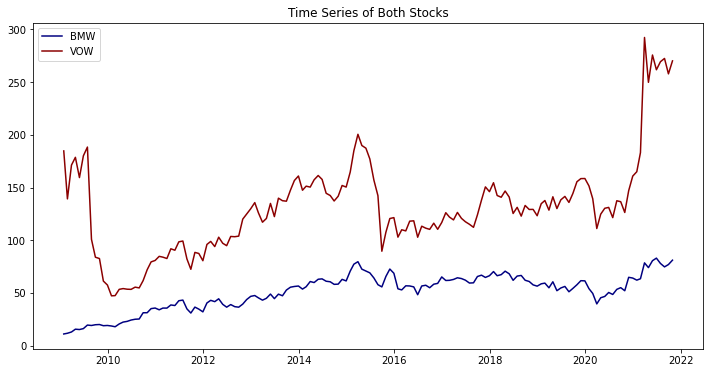

In [66]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(df['BMW'],color='navy')
heater, = plt.plot(df['VOW'], color='darkred')

#for year in range(2009, 2023):
    #plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['BMW', 'VOW'], fontsize=10)
plt.title('Time Series of Both Stocks')

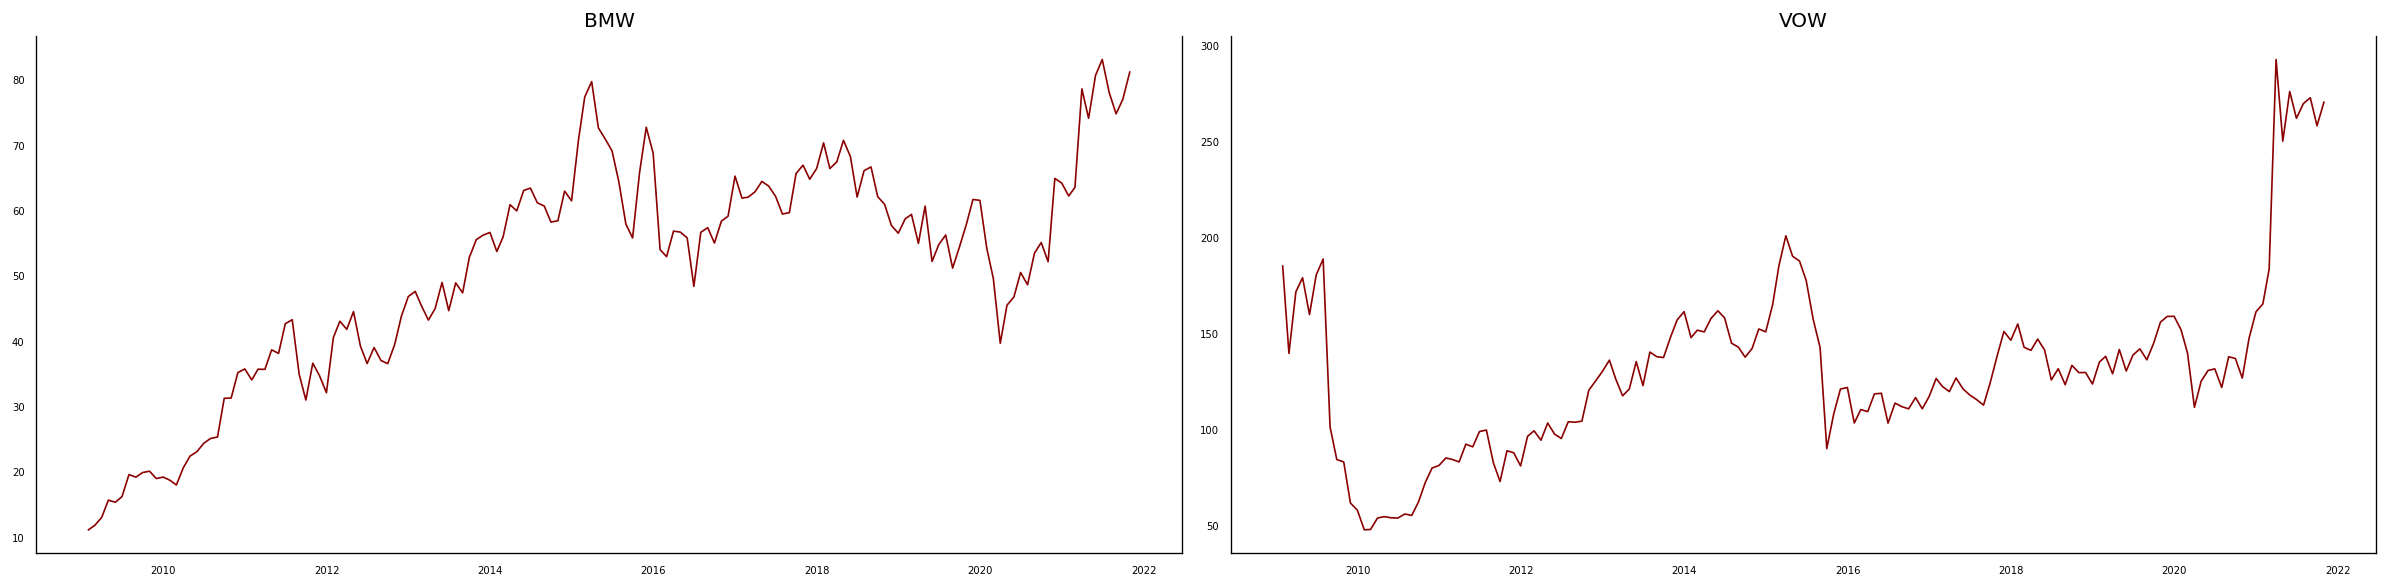

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(20,5))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='darkred', linewidth=1)

    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

La base de la autoregresión vectorial (VAR) es que cada una de las series temporales del sistema se influye mutuamente. Es decir, se puede predecir la serie con valores pasados de sí misma junto con otras series del sistema.

## Exploración de Datos

In [68]:
# Seleccionamos datos desde 2009/01, a 2021/10.
# train: 2009/01 a 2020/10
# test: 2020/10 a 2021/10

data_train=df['2009-01-30':'2020-10-31']
data_test=df['2020-10-30':'2021-10-31']


Text(0.5, 1.0, 'BMW')

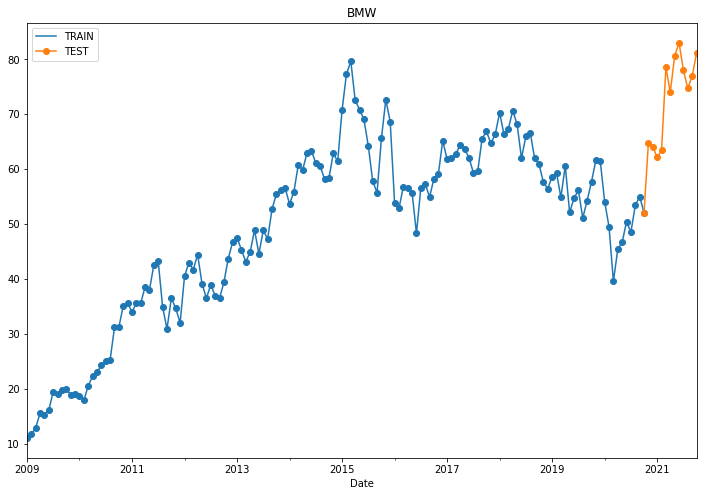

In [69]:
# Plot data 'BMW'
data_train['BMW'].plot(legend=True,label='TRAIN',marker='o')
data_test['BMW'].plot(legend=True,label='TEST',figsize=(12,8),marker='o')
plt.title('BMW')

Text(0.5, 1.0, 'VOW')

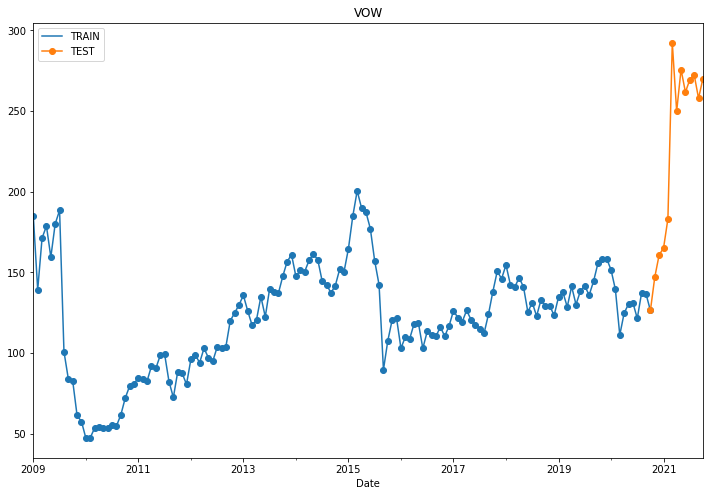

In [70]:
# Plot data 'VOW'
data_train['VOW'].plot(legend=True,label='TRAIN',marker='o')
data_test['VOW'].plot(legend=True,label='TEST',figsize=(12,8),marker='o')
plt.title('VOW')

In [71]:
# Transformacion estacionaria
# calcula la diferencia discreta de orden n a lo largo del eje dado
d_data_train=data_train.diff().dropna()
d_data_train

,BMW,VOW
Date,,
2009-02-28,0.677484,-45.505127
2009-03-31,1.212344,32.064621
2009-04-30,2.650517,7.370193
2009-05-31,-0.322978,-19.222229
2009-06-30,0.869282,20.648575
...,...,...
2020-06-30,3.745232,0.823639
2020-07-31,-1.881489,-9.700455
2020-08-31,4.836853,16.014893


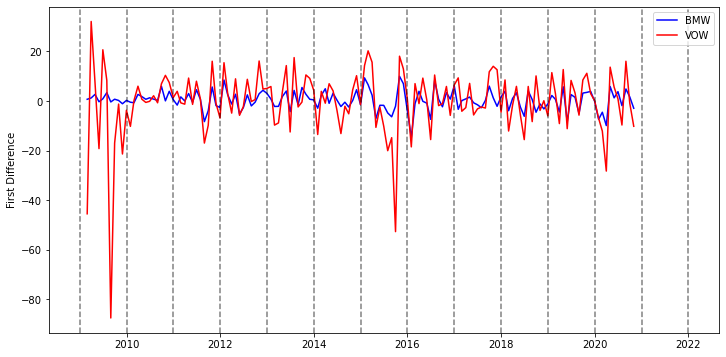

In [72]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(d_data_train['BMW'],color='blue')
heater, = plt.plot(d_data_train['VOW'], color='red')

for year in range(2009, 2023):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
plt.ylabel('First Difference', fontsize=10)
plt.legend(['BMW', 'VOW'], fontsize=10)

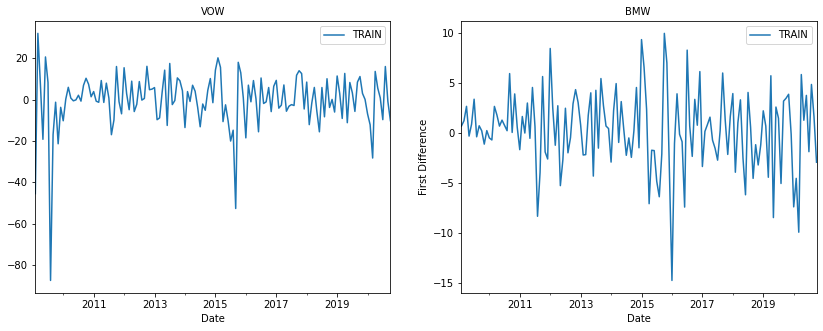

In [73]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

d_data_train['VOW'].plot(legend=True,label='TRAIN', ax=ax1)
ax1.set_title('VOW', fontsize=10)


d_data_train['BMW'].plot(legend=True,label='TRAIN', ax=ax2)
ax2.set_title('BMW ', fontsize=10)

plt.ylabel('First Difference', fontsize=10)
plt.show()

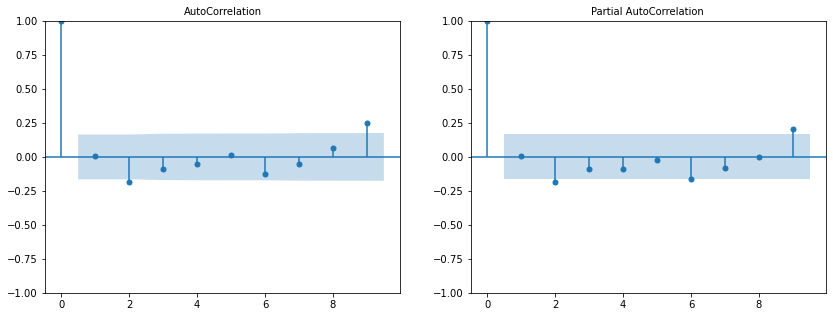

In [74]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot the autocorrelation function and partial autocorrelation function
# satsmodels
plt.close()
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_acf(d_data_train['BMW'].dropna(), lags=9, ax=ax1)
ax1.set_title('AutoCorrelation', fontsize=10)

plot_pacf(d_data_train['BMW'].dropna(), lags=9, method='ywm', ax=ax2)
ax2.set_title('Partial AutoCorrelation ', fontsize=10)

plt.show()
plt.close()

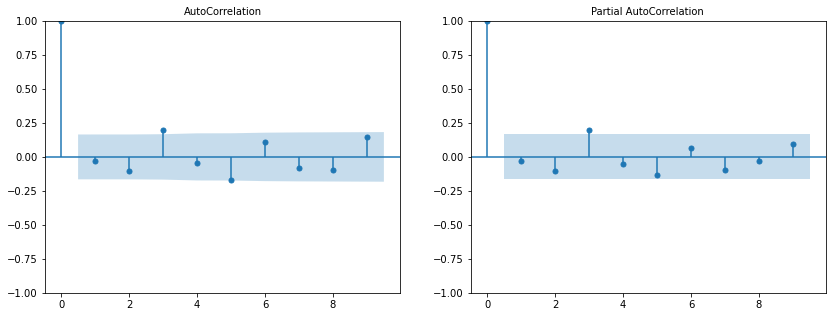

In [75]:
# Plot the autocorrelation function and partial autocorrelation function

# satsmodels
plt.close()
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_acf(d_data_train['VOW'].dropna(), lags=9, ax=ax1)
ax1.set_title('AutoCorrelation', fontsize=10)

plot_pacf(d_data_train['VOW'].dropna(), lags=9, method='ywm', ax=ax2)
ax2.set_title('Partial AutoCorrelation ', fontsize=10)


plt.show()
plt.close()

Estos graficos representan los retardos en el eje horizontal y las correlaciones en el vertical.
La autocorrelación para una observación y una observación en un paso de tiempo anterior está compuesta por la correlación directa y las correlaciones indirectas. Estas correlaciones indirectas son una función lineal de la correlación de la observación, con las observaciones en los pasos de tiempo intermedios. Son estas correlaciones indirectas las que la función de autocorrelación parcial trata de eliminar

La función de autocorrelación parcial da la correlación parcial de una serie temporal estacionaria con sus propios valores rezagados, con una regresión de los valores de la serie temporal en todos los rezagos más cortos. En cambio  la función de autocorrelación, no controla otros rezagos.

## Test de Granger

La causalidad de Granger prueba si una variable es util para pronosticar el comportamiento de otra variable. Prueba la hipotesis nula que los coeficientes de los valores pasados en la ecuacion de regresion es igual a 0. Si el pvalue es menor que 5% rechazaremos la H0, es decir, los valores pasados son significativos.

El estadístico del F-test resulta ser 1.6458 y el valor p correspondiente es 0.2017.

Como el valor p es mayor a 0,05, no podemos rechazar la hipótesis nula de la prueba y concluir que conocer el precio de BMW es útil para predecir el precio de VOW.

In [76]:
from statsmodels.tsa.stattools import grangercausalitytests

A continuación, utilizaremos la función grangercausalitytests() para realizar dos pruebas de Granger-Causalidad para ver si el precio de VOW ayuda a predecir el precio futuro de BMW. Haremos la prueba utilizando un maximo de 3 lags:

In [77]:
gc_res = grangercausalitytests(d_data_train[['BMW','VOW']], 3) 
#Usa un max de 3 lags en el primer time series


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=1.6818  , p=0.1947  , df=1
likelihood ratio test: chi2=1.6718  , p=0.1960  , df=1
parameter F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=2.3852  , p=0.3034  , df=2
likelihood ratio test: chi2=2.3650  , p=0.3065  , df=2
parameter F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9560  , p=0.4157  , df_denom=131, df_num=3
ssr based chi2 test:   chi2=3.0212  , p=0.3884  , df=3
likelihood ratio test: chi2=2.9886  , p=0.3934  , df=3
parameter F test:         F=0.9560  , p=0.4157  , df_denom=131, df_num=3


In [78]:
gc_res = grangercausalitytests(d_data_train[['VOW','BMW']], 3) 
#Usa un max de 30 lags en el primer time series


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1163  , p=0.2926  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=1.1407  , p=0.2855  , df=1
likelihood ratio test: chi2=1.1361  , p=0.2865  , df=1
parameter F test:         F=1.1163  , p=0.2926  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3506  , p=0.7049  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=0.7274  , p=0.6951  , df=2
likelihood ratio test: chi2=0.7255  , p=0.6958  , df=2
parameter F test:         F=0.3506  , p=0.7049  , df_denom=134, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8066  , p=0.1491  , df_denom=131, df_num=3
ssr based chi2 test:   chi2=5.7094  , p=0.1266  , df=3
likelihood ratio test: chi2=5.5944  , p=0.1331  , df=3
parameter F test:         F=1.8066  , p=0.1491  , df_denom=131, df_num=3


In [79]:
from scipy.stats import pearsonr


In [80]:
for lag in range(1, 10):
    bmw_series = d_data_train['BMW'].iloc[lag:]
    lagged_vow_series = d_data_train['VOW'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(bmw_series, lagged_vow_series))
    print('------')

Lag: 1
(-0.08656945276698741, 0.3091386897742209)
------
Lag: 2
(-0.169647886591995, 0.045873636110283465)
------
Lag: 3
(0.04670325723935154, 0.5864788996686808)
------
Lag: 4
(0.021080418737750548, 0.8068386756167703)
------
Lag: 5
(-0.023137703967108958, 0.789180544201453)
------
Lag: 6
(-0.07101300991021996, 0.41309568565431815)
------
Lag: 7
(-0.052249516026858046, 0.5487893882293087)
------
Lag: 8
(-0.007100771341385246, 0.935348018693429)
------
Lag: 9
(0.22010802259314982, 0.011213402931639268)
------


In [81]:
for lag in range(1, 10):
    VOW_series = d_data_train['VOW'].iloc[lag:]
    lagged_BMW_series = d_data_train['BMW'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(VOW_series, lagged_BMW_series))
    print('------')

Lag: 1
(0.060650420668088116, 0.4765593377708348)
------
Lag: 2
(-0.008517058912581525, 0.9207336052361348)
------
Lag: 3
(-0.03359993648675519, 0.6956271414970978)
------
Lag: 4
(-0.1042941347544111, 0.2251844592132572)
------
Lag: 5
(-0.04994168671006515, 0.5636694227306714)
------
Lag: 6
(-0.02810770485010091, 0.746233995295737)
------
Lag: 7
(-0.11000341788857049, 0.20576542469994102)
------
Lag: 8
(-0.14307752118771294, 0.10039549511268465)
------
Lag: 9
(0.19238357336936704, 0.02710632772328761)
------


El siguiente código implementa la prueba de causalidad de Granger para todas las posibles combinaciones de las series temporales en un marco de datos dado y almacena los valores p de cada combinación en la matriz de salida.
El valor mas bajo es **0.0344** y este valor se refiere al p valor de la causalidad de Granger del precio de BMW que causa al precio de VOW. Entonces, podemos rechazar la H0 y concluir que **el precio de BMW causa el precio de VOW**, por lo que podemos comenzar a intuir que BMW es líder y VOW es seguidor. 

In [82]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(d_data_train, variables, test='ssr_chi2test', verbose=False):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(d_data_train[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,BMW_x,VOW_x
BMW_y,1.0000,0.0812
VOW_y,0.0344,1.0000


## Modelo VAR

In [83]:
from statsmodels.tsa.api import VAR

In [84]:
# definir el VAR
model = VAR(d_data_train)
# maximo lag a seleccionar
model.select_order(20)

In [85]:
# estimar los modelos y seleccionar
results = model.fit(maxlags=20, ic='aic')

In [86]:
# lag con menor AIC
results.k_ar

2

In [87]:
# El modelo estimado
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Oct, 2022
Time:                     13:17:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.69313
Nobs:                     139.000    HQIC:                   7.56781
Log likelihood:          -904.465    FPE:                    1775.93
AIC:                      7.48202    Det(Omega_mle):         1654.74
--------------------------------------------------------------------
Results for equation BMW
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.287416         0.330788            0.869           0.385
L1.BMW         0.069048         0.102597            0.673           0.501
L1.VOW        -0.035054         0.030303           -1.157           0.247
L2.BMW        -0

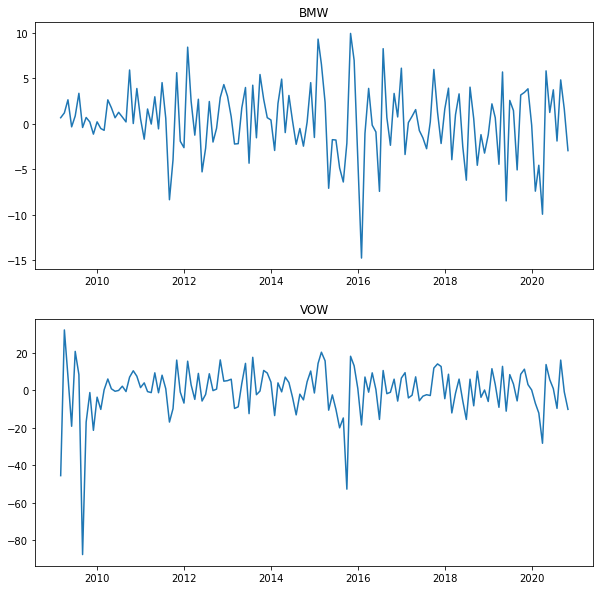

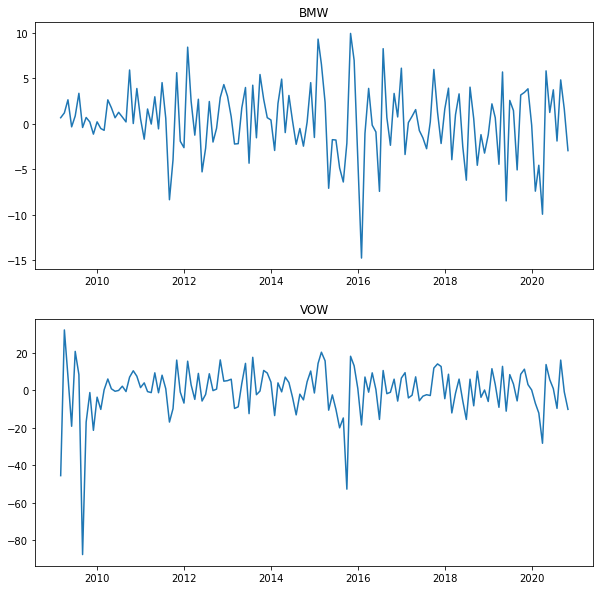

In [88]:
results.plot()

## Correlaciones de los residuos

No son ruido blanco

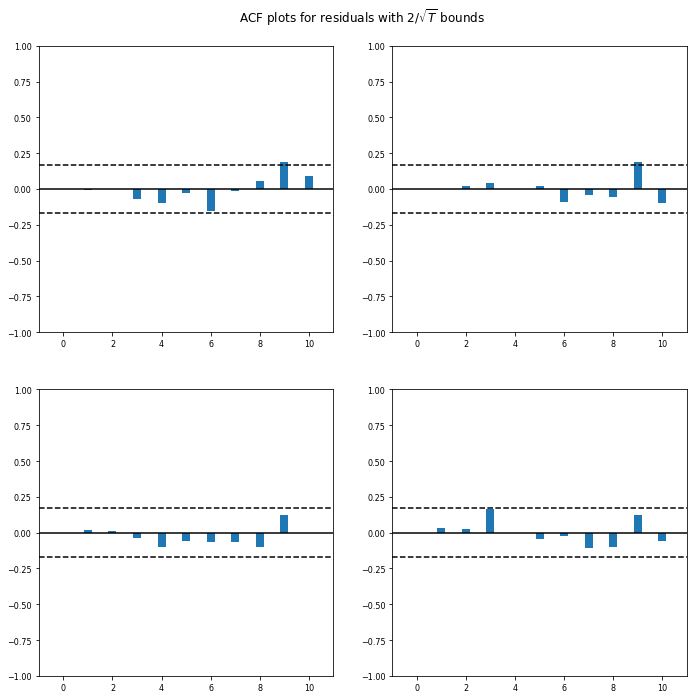

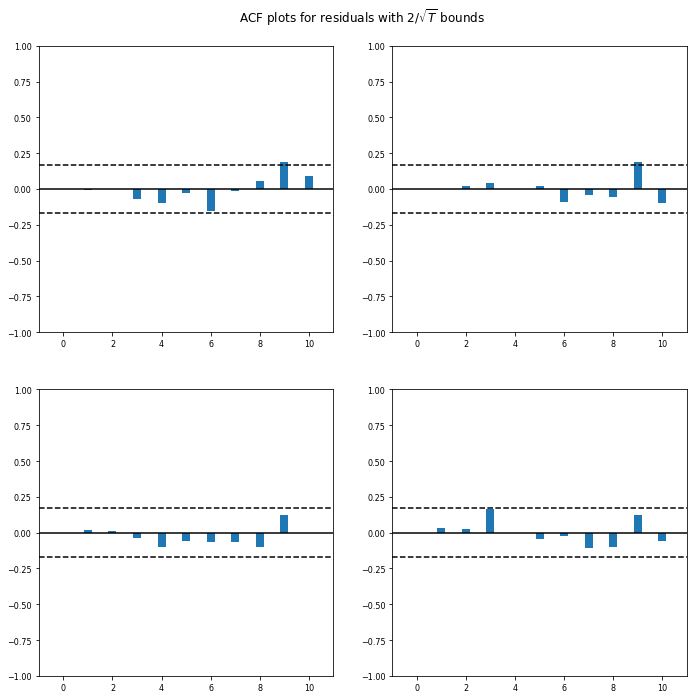

In [89]:
results.plot_acorr()

## Predicción
### Es necesario darle los valores iniciales, para la predicción recursiva. 
### Es el orden del VAR


In [90]:
lag_order = results.k_ar
lag_order

2

In [91]:
d_data_train.values[-lag_order:]

array([[  1.63299179,  -0.91513062],
       [ -2.93761444, -10.21200562]])

In [92]:
# Hacemos 13 predicciones
results.forecast(d_data_train.values[-lag_order:], 13)

array([[ 0.26600283, -0.42755317],
       [ 0.97649093,  0.27558373],
       [ 0.32436142, -0.21418599],
       [ 0.18828514, -0.2495492 ],
       [ 0.27501983, -0.35521004],
       [ 0.30260725, -0.36760332],
       [ 0.29719596, -0.32849796],
       [ 0.29238142, -0.32139299],
       [ 0.29135642, -0.32881841],
       [ 0.29194081, -0.33105262],
       [ 0.2923984 , -0.33016879],
       [ 0.2923902 , -0.3296554 ],
       [ 0.29228965, -0.3296737 ]])

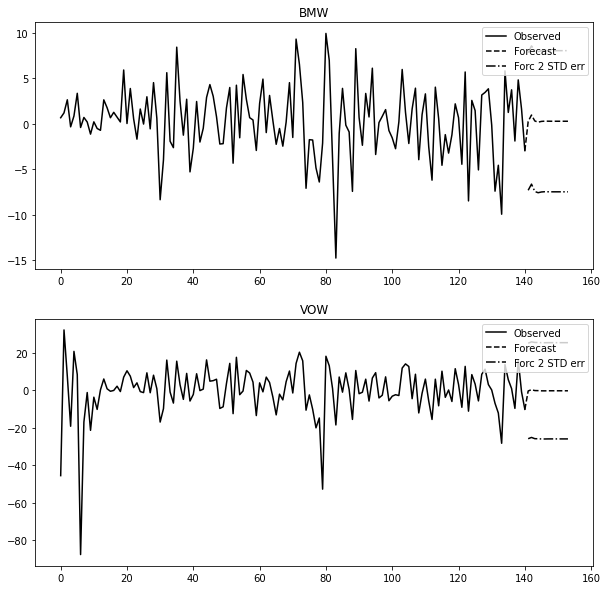

In [93]:
results.plot_forecast(13);

In [94]:
f_data=data_train.values[-1:]+results.forecast(d_data_train.values[-lag_order:], 13)
f_data

array([[ 52.34426134, 125.8988781 ],
       [ 53.05474944, 126.602015  ],
       [ 52.40261993, 126.11224529],
       [ 52.26654365, 126.07688208],
       [ 52.35327835, 125.97122124],
       [ 52.38086577, 125.95882795],
       [ 52.37545447, 125.99793332],
       [ 52.37063993, 126.00503828],
       [ 52.36961493, 125.99761287],
       [ 52.37019932, 125.99537865],
       [ 52.37065691, 125.99626249],
       [ 52.37064871, 125.99677588],
       [ 52.37054816, 125.99675757]])

In [95]:
data_fore=pd.DataFrame(f_data)
data_fore.index=data_test.index
data_fore.rename(columns={0: 'F_BMW', 1: 'F_VOW'}, inplace=True)
data_fore

,F_BMW,F_VOW
Date,,
2020-10-31,52.344261,125.898878
2020-11-30,53.054749,126.602015
2020-12-31,52.402620,126.112245
2021-01-31,52.266544,126.076882
2021-02-28,52.353278,125.971221
2021-03-31,52.380866,125.958828
2021-04-30,52.375454,125.997933
2021-05-31,52.370640,126.005038
2021-06-30,52.369615,125.997613


Text(0.5, 1.0, 'Predicción BMW')

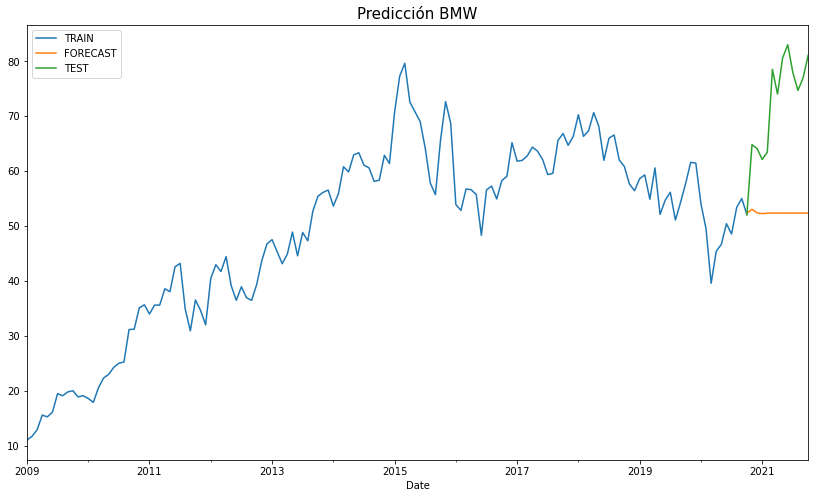

In [96]:
data_train['BMW'].plot(legend=True,label='TRAIN',)
data_fore['F_BMW'].plot(legend=True,label='FORECAST')
data_test['BMW'].plot(legend=True,label='TEST',figsize=(14,8))

plt.title('Predicción BMW',fontsize=15)

Text(0.5, 1.0, 'Predicción VOW')

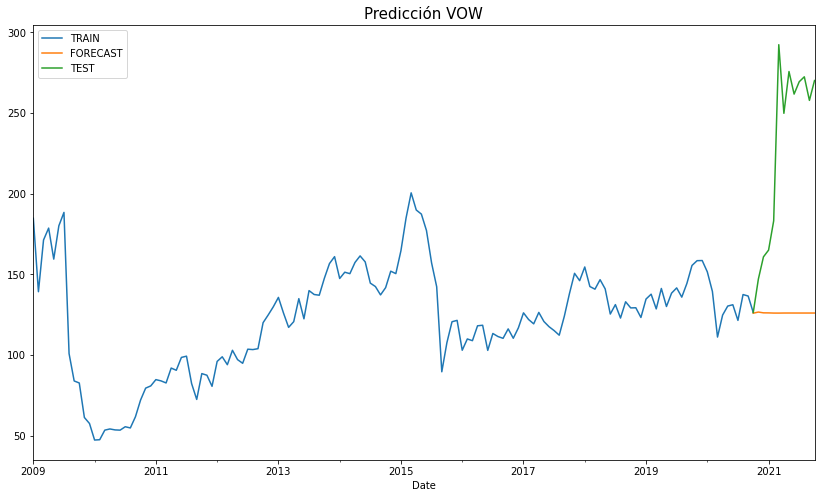

In [97]:
data_train['VOW'].plot(legend=True,label='TRAIN',)
data_fore['F_VOW'].plot(legend=True,label='FORECAST')
data_test['VOW'].plot(legend=True,label='TEST',figsize=(14,8))

plt.title('Predicción VOW',fontsize=15)

Las métricas de error nos permiten hacer un seguimiento de la eficiencia y la precisión a través de varias métricas. Vamos a utilizar el RMSE con el que podemos representar fácilmente la diferencia entre los valores estimados y reales de un parámetro del modelo.

El error cuadrático medio es la raíz cuadrada de la media de las diferencias al cuadrado entre el valor estimado y el valor real de la variable.

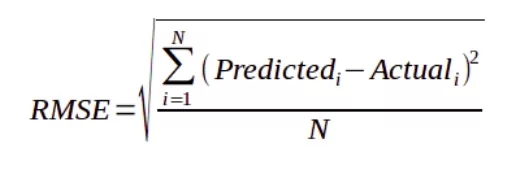

In [98]:
RMSE=rmse(data_fore['F_BMW'],data_test['BMW'])
print("Root Mean Square Error of BMW:\n")
print(RMSE)


Root Mean Square Error of BMW:

21.41934188496841


In [99]:
RMSEVOW= rmse(data_fore['F_VOW'],data_test['VOW'])
print("Root Mean Square Error of VOW:\n")
print(RMSEVOW)

Root Mean Square Error of VOW:

114.50311023149271


vemos que el RMSE de VOW es mucho mas alto. esto se debe a que los valores de VOW son mucho mayores que los de BMW y la volatilidad de estos es mucho más grande

## Función de Respuesta al Impulso

In [100]:
irf = results.irf(12)

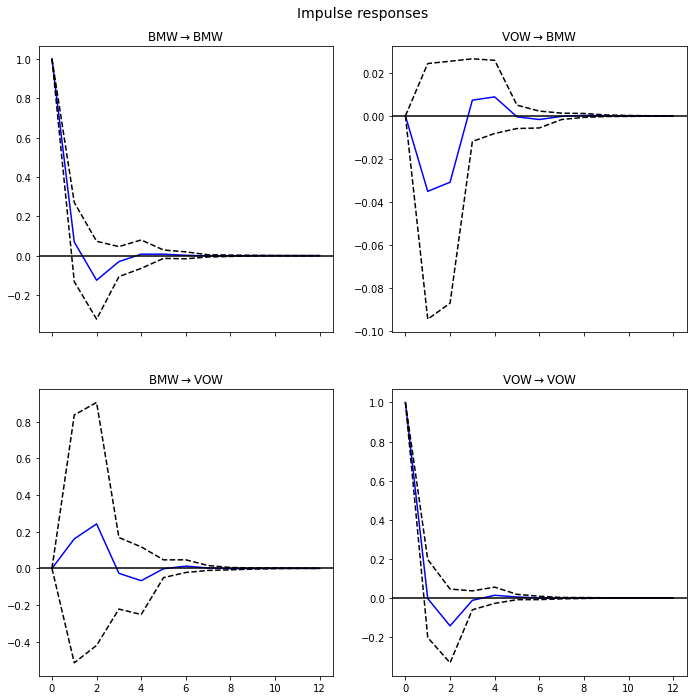

In [101]:
irf.plot(orth=False);

## Descomposición del error de predicción

In [102]:
fevd = results.fevd(5)

In [103]:
fevd.summary()

FEVD for BMW
          BMW       VOW
0    1.000000  0.000000
1    0.990910  0.009090
2    0.984518  0.015482
3    0.984146  0.015854
4    0.983610  0.016390

FEVD for VOW
          BMW       VOW
0    0.339078  0.660922
1    0.340476  0.659524
2    0.336023  0.663977
3    0.336141  0.663859
4    0.336193  0.663807




## Modelo GARCH. BMW

Vamos a comprobar si la volatilidad de BMW es constante con el Modelo GARCH. Para ello utilizamos datos diarios.

In [144]:
dfBMW=bmw['2009-01-31':'2020-10-31']
dfBMW=dfBMW[['Adj Close']]
dfBMW=dfBMW[['Adj Close']].rename(columns={'Adj Close':'Price'})
dfBMW

,Price
Date,
2009-02-02,10.465376
2009-02-03,10.771434
2009-02-04,11.511318
2009-02-05,11.645033
2009-02-06,12.994062
...,...
2020-10-26,56.098618
2020-10-27,54.554375
2020-10-28,51.528015


La serie temporal de los rendimientos es igual a la rentabilidad media más la rentabilidad no esperada (error)

                    rt = m + E

In [145]:
# Log return

dfBMW['log_return'] =np.log(dfBMW.Price).diff()


In [146]:
# Squared Log return
# Proxy Volatility

dfBMW['Squared'] =dfBMW['log_return']**2
dfBMW.head()

,Price,log_return,Squared
Date,,,
2009-02-02,10.465376,NaN,NaN
2009-02-03,10.771434,0.028825,0.000831
2009-02-04,11.511318,0.066433,0.004413
2009-02-05,11.645033,0.011549,0.000133
2009-02-06,12.994062,0.109613,0.012015


Las herramientas para la identificación y diagnosis del modelo GARCH son:
 - 1. Gráfico de los rendimientos al cuadrado o valor absoluto
 - 2. ACF y PACF de los rendimientos al cuadrado
 - 3. Test Ljung-Box de los rendimientos al cuadrado
 - 4. Test de Multiplicadores de Langrange de Engle (LM) 

#### 1. Gráfico de los rendimientos al cuadrado o valor absoluto

Text(0.5, 1, 'Volatilidad')

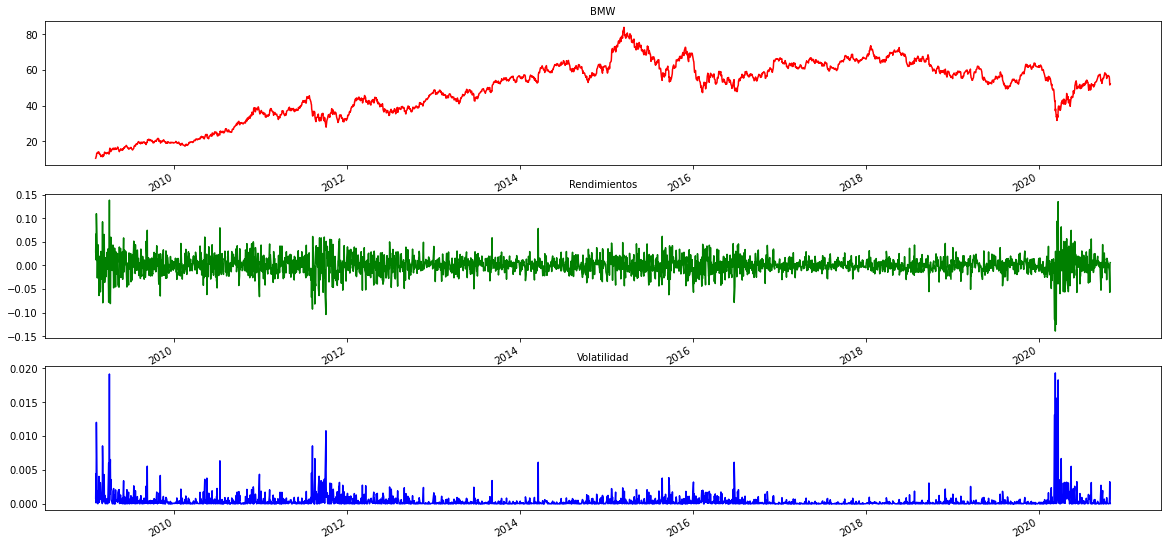

In [148]:
#Plot
fig = plt.figure(figsize=(20,10))
plt.subplot(311)
ax=dfBMW.Price.plot( linestyle='-',color='red')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('BMW', y=1,x=0.5, fontsize = 10)
plt.subplot(312)
ax=dfBMW.log_return.plot( linestyle='-',color='green')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Rendimientos', y=1, x=0.5,fontsize = 10)
plt.subplot(313)
ax=dfBMW.Squared.plot( linestyle='-',color='blue')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Volatilidad', y=1,X=0.5, fontsize = 10)

#### 1.1 Prueba de la Media. Rentabilidad 

In [149]:
# mean zero test
# Calculate the T-test for the mean of ONE group of scores
# This is a test for the null hypothesis that the expected value (mean) of a sample of 
#    independent observations a is equal to the given population mean, popmean.


from scipy import stats
alpha=0.05
t, p =stats.ttest_1samp(dfBMW['log_return'].dropna(),0.0)
print ('Estadítico t:',t)
print ('p-value:',p)

if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Estadítico t: 1.5086275053506317
p-value: 0.13150000888082572
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.


Podemos afirmar que la media de los retornos es cero, por tanto, la serie temporal de los rendimientos va a ser igual a la rentabilidad no esperada, es decir, al error (mean connected error).

In [150]:
# Autocorrelation Fuction Original Time Series
from sktime.utils.plotting import plot_correlations

In [151]:
# Create proxy Volatility 
bmw_vol=dfBMW['Squared'].astype('float64').to_period('D').sort_index().dropna()
bmw_vol.tail()

Date
2020-10-26    0.000128
2020-10-27    0.000779
2020-10-28    0.003257
2020-10-29    0.000022
2020-10-30    0.000036
Freq: D, Name: Squared, dtype: float64

#### 2. ACF y PACF de los rendimientos al cuadrado


(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Squared'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

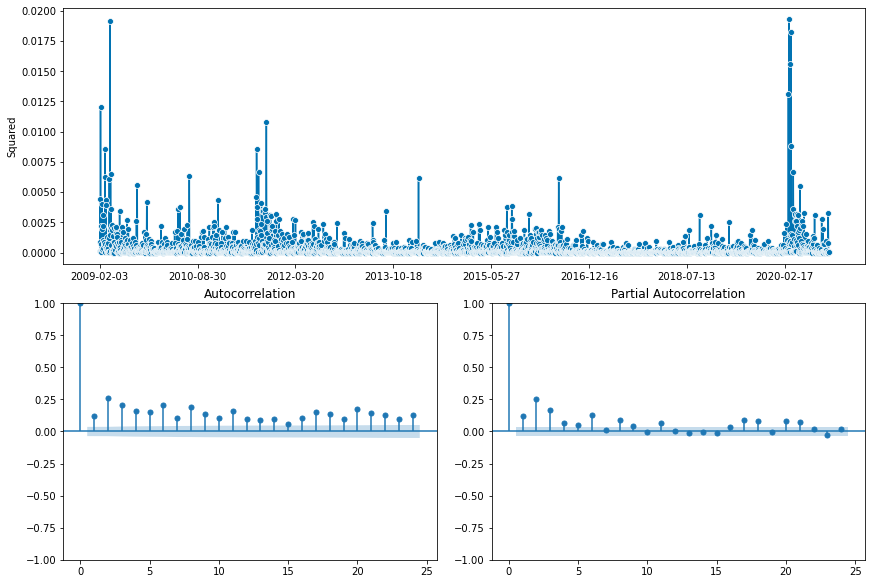

In [152]:
# Plot Autocorrelation
plot_correlations(bmw_vol)

Alta correlación con los anteriores retardos.

#### 3. Ljung-Box Test

In [153]:
# import function test Ljung_Box
import statsmodels.api as sm
test_Ljung_Box=sm.stats.acorr_ljungbox

El ruido blanco es una señal aleatoria (proceso estocástico) que se caracteriza por el hecho de que sus valores de señal en dos tiempos diferentes no guardan correlación estadística. Como consecuencia de ello, su densidad espectral de potencia (PSD, sigla en inglés de power spectral density) es una constante, es decir, su gráfica es plana. Esto significa que la señal contiene todas las frecuencias y todas ellas muestran la misma potencia.

In [154]:
# testing Ljung-Box
# Ho: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(bmw_vol, lags=[1,2,3], return_df=True)

,lb_stat,lb_pvalue
1,44.973629,1.997058e-11
2,252.967927,1.171420e-55
3,381.230487,2.573477e-82


todos los p value son menores que alpha (0.05) por lo que no hay ruido blanco en la varianza con ninguno de los 3 retardos. hay garch.b

#### 4. LM Arch Test

In [155]:
# import function test LM-Arch
import statsmodels.api as sm
test_LM_ARCH=sm.stats.diagnostic.het_arch

In [182]:
# testing LM-ARCH
# pvalue < alpha -> ARCH
lm, lmpval, f, pval, result_int =test_LM_ARCH(dfBMW['log_return'].dropna(), nlags=2, store=True)
print ('Estadístico LM: ', lm)
print ('p-value: ', lmpval)
print ('Estadístico F: ', f)
print ('p-value: ', pval)

Estadístico LM:  233.1850504180245
p-value:  2.314779729307697e-51
Estadístico F:  126.36662025415988
p-value:  2.118038479782674e-53


In [157]:
result_int.resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     126.4
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.12e-53
Time:                        13:27:11   Log-Likelihood:                 16373.
No. Observations:                2979   AIC:                        -3.274e+04
Df Residuals:                    2976   BIC:                        -3.272e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   2.03e-05     12.220      0.000       0.000       0.000
x1             0.0912      0.018      5.155      0.000       0.056       0.126
x2             0.2528      0.018     14.292      0.000       0.218       0.287
==============================================================================
Omnibus:                     4530.217   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2336415.563
Skew:                           9.291   Prob(JB):                         0.00
Kurtosis:                     138.933   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- r squared y adj r squared muy bajos: 0.104
- AIC muy bajo--> bueno


#### ARCH Model

In [158]:
#pip install arch

In [159]:
from arch.univariate import ARX
from arch.univariate import ARCH, GARCH

Los modelos de series temporales ARX son una representación lineal de un sistema dinámico en tiempo discreto. Poner un modelo en forma de ARX es la base de muchos métodos de dinámica de procesos y análisis de control. 

In [183]:
ar = ARX(100*dfBMW['log_return'].dropna(), lags=[1])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:             log_return   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.002
Vol Model:          Constant Variance   Log-Likelihood:               -6211.54
Distribution:                  Normal   AIC:                           12429.1
Method:            Maximum Likelihood   BIC:                           12447.1
                                        No. Observations:                 2980
Date:                Mon, Oct 31 2022   Df Residuals:                     2978
Time:                        13:30:50   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0504  3.571e-02      1.412

In [184]:
# MODELO ERRONEO
# ARCH(1)
ar.volatility = ARCH(p=1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - ARCH Model Results                            
Dep. Variable:             log_return   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -6126.18
Distribution:                  Normal   AIC:                           12260.4
Method:            Maximum Likelihood   BIC:                           12284.4
                                        No. Observations:                 2980
Date:                Mon, Oct 31 2022   Df Residuals:                     2978
Time:                        13:30:55   Df Model:                            2
                                  Mean Model                                  
                    coef    std err          t      P>|t|     95.0% Conf. Int.
------------------------------------------------------------------------------
Const             0.0588  3.538e-02      1.662  9.65

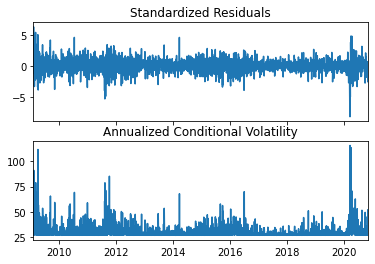

In [185]:

fig = res.plot(annualize="D")

## GARCH (1,1)

In [186]:
# MODELO 
# GARCH(1,1)
ar.volatility = GARCH(p=1,q=1) #p=orden de retardo
                               #q=orden de la volatilidad retardada
                                #si q=0, tendriamos un modelo ARCH
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:             log_return   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -5826.31
Distribution:                  Normal   AIC:                           11662.6
Method:            Maximum Likelihood   BIC:                           11692.6
                                        No. Observations:                 2980
Date:                Mon, Oct 31 2022   Df Residuals:                     2978
Time:                        13:30:56   Df Model:                            2
                                  Mean Model                                 
                    coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------------------
Const             0.0593  2.975e-02      1.994  4.610e-

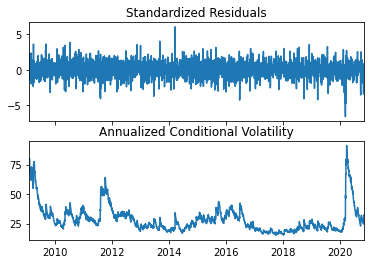

In [187]:
#
fig = res.plot(annualize="D")

In [188]:
# Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

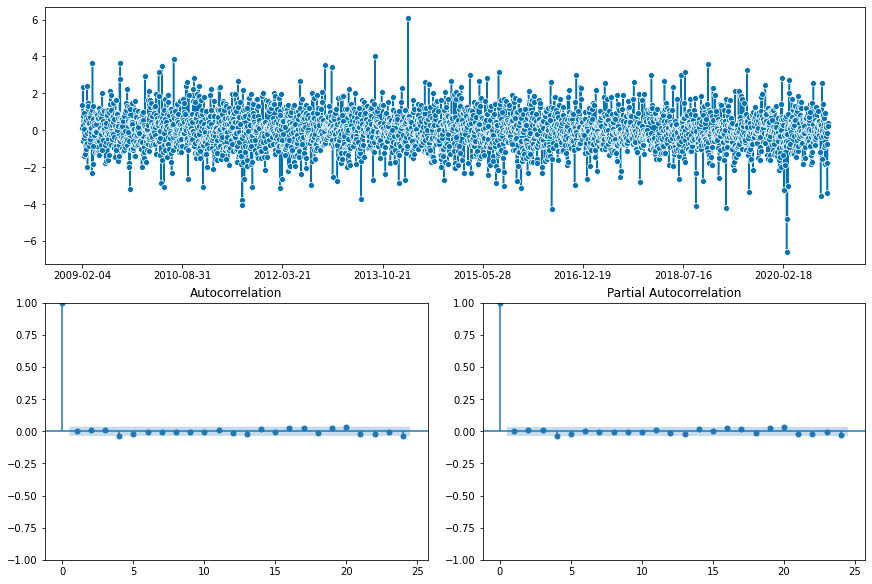

In [189]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

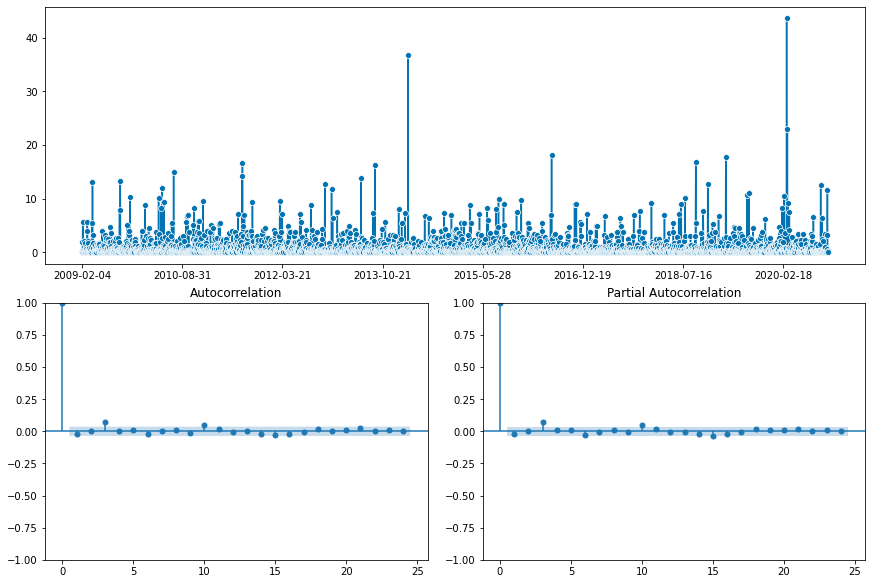

In [190]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)

In [191]:
#
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,27.941657,0.001844
20,35.720605,0.016586
30,40.954189,0.087667


 ## GARCH(1,1) + t-student


In [192]:
from arch.univariate import StudentsT

In [193]:
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                   log_return   R-squared:                       0.002
Mean Model:                              AR   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -5739.52
Distribution:      Standardized Student's t   AIC:                           11491.0
Method:                  Maximum Likelihood   BIC:                           11527.0
                                              No. Observations:                 2980
Date:                      Mon, Oct 31 2022   Df Residuals:                     2978
Time:                              13:31:01   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

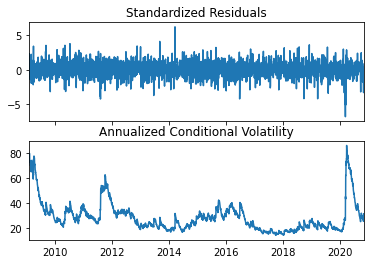

In [194]:
fig = res.plot(annualize="D")

In [195]:
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

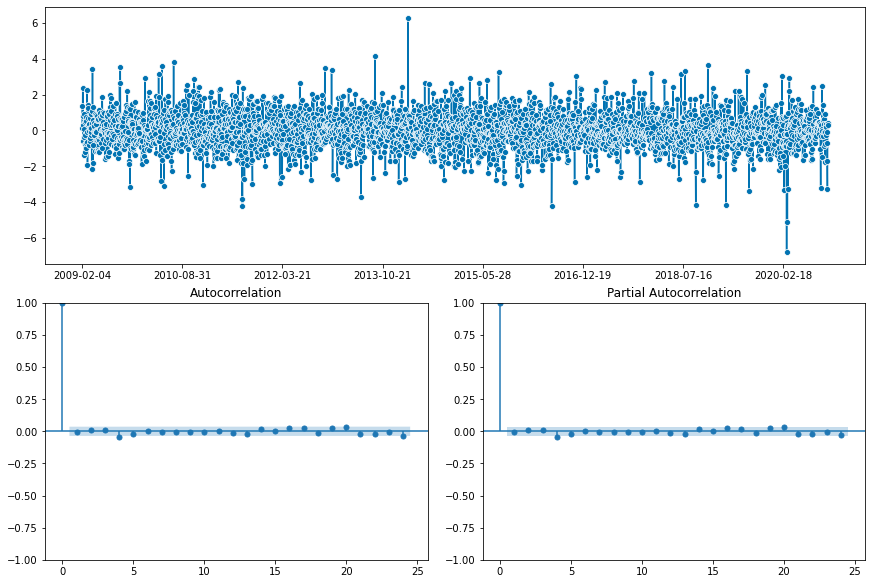

In [196]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid)

Es el modelo más utilizado. Es una ARMA(1,1) sobre la varianza de los errores. Aqui vemos que hay ruido blanco.

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

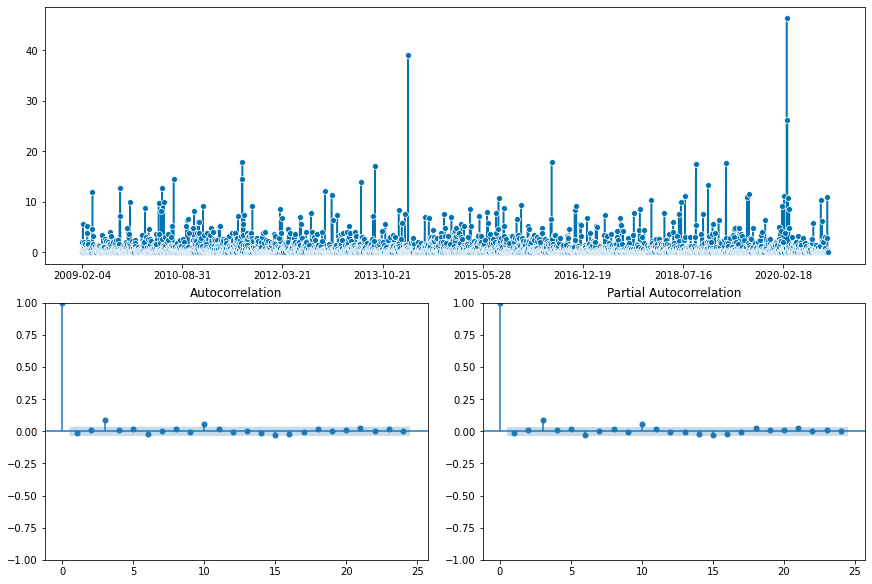

In [197]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)

In [198]:
#
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[1,2,3,4], return_df=True)

,lb_stat,lb_pvalue
1,0.586803,0.443658
2,1.119410,0.571378
3,25.185356,0.000014
4,25.361994,0.000043


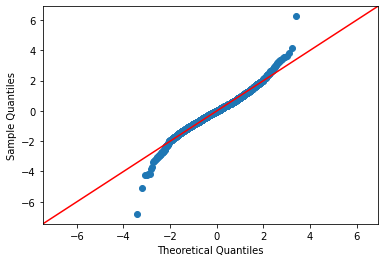

In [199]:
# qqplot normal
sm.qqplot(mod1_std_resid,line='45')
plt.show()

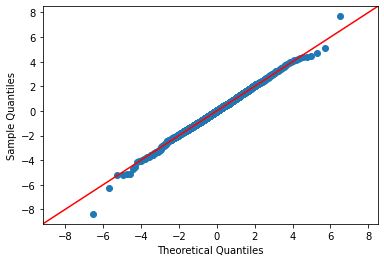

In [200]:
# qqplot t-student
sm.qqplot(mod1_std_resid,dist=stats.t,fit=True,line='45')
plt.show()

Gráfico de los cuantiles de x frente a los cuantiles de la distribución.

Afirmamos que si sigue una distribucion normal.

 ## Forecast Volatility


#### Predicción noviembre 2020  (21 días)


In [201]:
forecasts = res.forecast(horizon=21, reindex=False) 
# horizonte de prediccion 21 dias

In [202]:
forecasts.mean

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.12,h.13,h.14,h.15,h.16,h.17,h.18,h.19,h.20,h.21
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-30,0.068693,0.033049,0.03065,0.030489,0.030478,0.030477,0.030477,0.030477,0.030477,0.030477,...,0.030477,0.030477,0.030477,0.030477,0.030477,0.030477,0.030477,0.030477,0.030477,0.030477


In [203]:
df_mean=pd.DataFrame(forecasts.mean).T
df_mean

Date,2020-10-30
h.01,0.068693
h.02,0.033049
h.03,0.030650
h.04,0.030489
h.05,0.030478
h.06,0.030477
h.07,0.030477
h.08,0.030477
h.09,0.030477
h.10,0.030477


In [204]:
#varianza
#multiplico por la raiz cuadrada de 252, que son los dias del año.
df_var=pd.DataFrame((forecasts.variance**0.5)*np.sqrt(252)).T
df_var

Date,2020-10-30
h.01,30.579258
h.02,30.645409
h.03,30.642678
h.04,30.639651
h.05,30.636636
h.06,30.633635
h.07,30.630649
h.08,30.627677
h.09,30.624719
h.10,30.621776


 h.1 corresponds to one-step ahead forecasts while h.10 corresponds to 10-steps ahead

Valores reales de noviembre:

In [205]:
Adj=bmw[['Adj Close']]

BMW_nov=Adj['2020-11-01':'2020-11-30']
BMW_nov

,Adj Close
Date,
2020-11-02,52.965759
2020-11-03,55.131245
2020-11-04,55.486248
2020-11-05,57.500862
2020-11-06,56.426991
2020-11-09,60.021347
2020-11-10,61.680969
2020-11-11,62.426456
2020-11-12,62.745956
